# 8.2 Global Sensitivity Analysis with modification of the Technosphere Matrix

(This notebook is courtesy of Pierre Jouannais)

As you may have seen in the previous notebook, dealing with parameters in Brightway can be a bit tidious and not very intuitive. Let's see another way to use parameters **without** using the parameters management from Brightway.










Let's imagine another case for GSA where it is hard to tell a priori which of the uncertain parameters are responsible for most of the variance in the output of the LCA. The sensitivy analysis is going to identify these parameters for us.
Imagine a fictive product system with 4 parameters defined as follows:




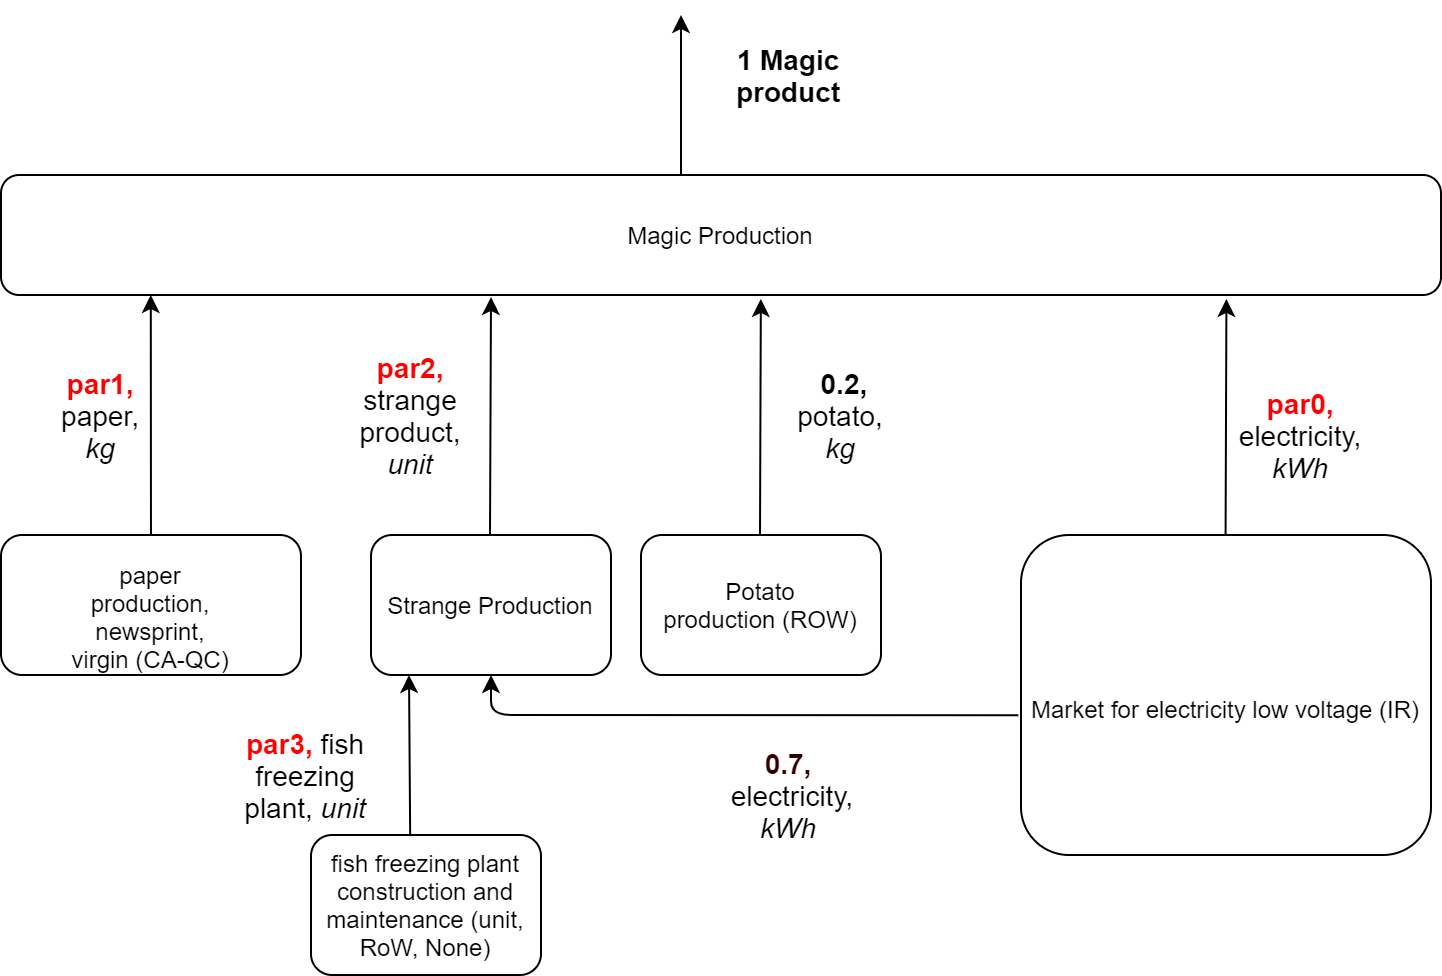

In [1]:
import numpy as np
import scipy as sp
import brightway2 as bw

In [ ]:
bw.projects.set_current('advlca21') # Still working in the same project
bw.databases

We create a new Database for this product system.

Note that there is no field "formula" for the amounts of each exchange as we are not using Brightway's parameters management.


In [3]:
gsa_db_Magic = bw.Database('gsa_db_Magic')
gsa_db_Magic.write({  
    ('gsa_db_Magic', 'magic_prod_for_sa'): {
        'name': 'Magic Prod',
        'unit': 'Magic Unit',
        'exchanges': [{                  
            'input': ('ecoinvent 3.6 conseq', '4f22a6931ee45c49b503855a78d8f362'),  # electricity 
            'amount': 0.2, # Consider this as 'par0'
            'type': 'technosphere'},  
        { 
            'input': ('ecoinvent 3.6 conseq', '2d0b0fac79566c4b323cb1c07da8712b'), # potatoe
            'amount': 0.2,  # Not a parameter (fixed value)
            'type': 'technosphere'},    
 
        { 
            'input':  ('ecoinvent 3.6 conseq', '6078300cbcfb93b3940948289c2e329b'), # paper
            'amount': -0.0000002, # Consider this as 'par1'
            'type': 'technosphere'},  
        { 
            'input': ('gsa_db_Magic', 'strange_input_for_sa'), # strange product
            'amount': 0.2, # Consider this as 'par2'
            'type': 'technosphere'},
        {
            'input': ('gsa_db_Magic', 'magic_prod_for_sa'),
            'amount': 1.0, # Not a parameter (fixed value)
            'type': 'production'}]
    },
    ('gsa_db_Magic', 'strange_input_for_sa'): {
        'name': 'Strange Input',
        'unit': 'Strange Unit',
        'exchanges': [{
            'input': ('ecoinvent 3.6 conseq', 'e56bd16baa0faf947cdf440919731dc0'),  # fish freezing plant
            'amount': 13, # Consider this as 'par3'
            'type': 'technosphere'},  
        { 
            'input': ('ecoinvent 3.6 conseq', '7b11078cc95d385daf52fde69d03c94d'), # electricity
            'amount': 0.7, # Not a parameter (fixed value)
            'type': 'technosphere'},    
        {
            'input': ('gsa_db_Magic', 'strange_input_for_sa'),
            'amount': 1.0, # Not a parameter (fixed value)
            'type': 'production'}]}})

Writing activities to SQLite3 database:
0% [##] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 04/12/2022 12:51:29
  Finished: 04/12/2022 12:51:29
  Total time elapsed: 00:00:00
  CPU %: 41.40
  Memory %: 0.93




Our activity is not parameterized so far. But of course,  we will to need to make it parameterized in some way for our sensitivity analysis! The trick is that we will do this at the last moment of our calculation. So for now let's think of them as parameters.

## Step 1. Define parameters and their ranges in form of a problem


We define the problem for the GSA analysis exactly like in the previous notebook.

We assume the uncertainties for our input parameters can all be modeled as uniform distributions.

In [4]:
problem = { 'num_vars': 4, # number of variables
            'names': ['par0', 'par1', 'par2', 'par3'], # names of variables, same as parameters
            'bounds': [[4, 5], 
                       [-0.001, -0.0002],  
                       [0.005, 0.01],
                       [0.4, 0.5]] ,
           'dists':["unif","unif","unif","unif"] } # all uniform distributions

## Step 2. Generate the samples



Now, we generate a pseudo-random sample using a sampling method from the SALib package on the problem we have defined.

We are going to use a __FAST__ sample ("Fourier Amplitude Sensitivity Analysis") which is another alternative to Sobol. 

Sobol and FAST sampling methods use different pseudo-random patterns to cover the space of parameters, and different calculations for the sensitivity indices.

Besides these differences, the (extended) FAST method is, just like the Sobol one, a Variance-Based sensitivity analysis. It provides the same information as the Sobol method. It was developped for its computational efficiency compared to Sobol.
For further information and comparison.

Litterature reference for FAST:

(1) Saltelli, A.; Tarantola, S.; Chan, K. P. S. A Quantitative Model-Independent Method for Global Sensitivity Analysis of Model Output. Technometrics 1999, 41 (1), 39–56. https://doi.org/10.1080/00401706.1999.10485594.






In [5]:
from SALib.sample import saltelli
from SALib.sample import fast_sampler
from SALib.analyze import sobol
from SALib.analyze import fast

As we have seen in a previous notebook, a large sample size is usually needed to obtain a reasonable confidence interval for the index. So we will directly start with a relatively large sample size.



In [6]:
param_values_FAST= fast_sampler.sample(problem, 200) # FAST sampler creates N*P parameters sets with N=sample size, P = number of parameters
print(param_values_FAST.shape)

(800, 4)


## Step 3. Use the generated parameters set as inputs to our LCA model


### 3.1 Modifying the technosphere matrix

Remember that nothing has actually been parameterized in our system so far. So we need to change values in specific places in our product system where the parameters are. We can do this by modifying the technology matrix.

Observe what happens when we calculate a life cycle inventory for our functional unit.

In [7]:
LCA = bw.LCA({('gsa_db_Magic', 'magic_prod_for_sa') : 1}, 
             ('IPCC 2013', 'climate change', 'GWP 100a'))
LCA.lci()


*LCA.lci()* generates the technosphere matrix that you can call with *LCA.technosphere_matrix*

In [8]:
print(LCA.technosphere_matrix)

  (0, 0)	1.0
  (0, 13648)	-0.3333333432674408
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (3, 9701)	-0.9998473525047302
  (4, 4)	-1.0
  (4, 5511)	600.0
  (4, 5755)	36.099998474121094
  (4, 6418)	10.800000190734863
  (4, 9788)	2.5999999046325684
  (4, 10028)	19.0
  (4, 11872)	17.399999618530273
  (4, 13437)	59.20000076293945
  (4, 16119)	718.0
  (5, 5)	1.0
  (5, 14770)	-0.9501222372055054
  (6, 6)	1.0
  (6, 11534)	-0.649518609046936
  (7, 7)	1.0
  (7, 9867)	-1.7193420021044403e-08
  (7, 16151)	-0.003340348834171891
  (8, 8)	1.0
  (8, 584)	-0.05889463052153587
  (9, 9)	1.0
  :	:
  (16457, 12474)	-0.002133999951183796
  (16457, 12530)	-4.195266683382215e-06
  (16457, 12829)	-1.500000053056283e-07
  (16457, 12885)	-0.0017999999690800905
  (16457, 13028)	-5.825551397720119e-06
  (16457, 13130)	-1.3365477613547228e-08
  (16457, 13996)	-1.6699999605407356e-07
  (16457, 14107)	-0.0017999999690800905
  (16457, 14192)	-0.0017999999690800905
  (16457, 14198)	-1.7499999671599653e-07
  (16457, 14875)	

It looks messy because it is a huge sparse matrix but it is actually the technosphere matrix (with the inital values we gave to our parameters):

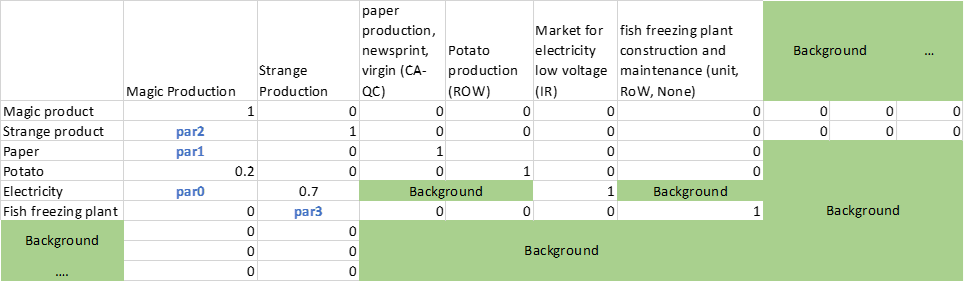

From this technosphere matrix, Brigthway can calculate the LCIA:

In [9]:
LCA.lcia()

LCA.score

6.358974024980306

We now directly modify the technosphere matrix before the Life cycle Impact Assessment.

For instance, let's say we want to change the value of par0 which is the amount of the exchange from input *('ecoinvent 3.6 conseq', '4f22a6931ee45c49b503855a78d8f362')* to activity *('gsa_db_Magic', 'magic_prod_for_sa')*.



In [10]:
# The location of this amount (par0) is located in the technosphere matrix as follows :

column = LCA.activity_dict[('gsa_db_Magic', 'magic_prod_for_sa')] # find index of tech matrix for the activity
row = LCA.activity_dict[('ecoinvent 3.6 conseq', '4f22a6931ee45c49b503855a78d8f362')] # find index of tech matrix for the exchange

# We change the value of this amount.

LCA.technosphere_matrix[row,column] = -10 # note the "-" which means an input in Brightway conventions
        

And now let's recalculate the LCIA


In [11]:
LCA.redo_lci() #Redo the LCI with the new technosphere matrix
LCA.lcia()
LCA.score

11.55320496144216

It has definetly taken our modification into account.


Let's automate this for our sensitivity analysis.

### 3.2 Applying the technosphere matrix modifications to the GSA

In [12]:
#First, generate the technosphere matrix
LCA = bw.LCA({('gsa_db_Magic', 'magic_prod_for_sa') : 1}, 
             ('IPCC 2013', 'climate change', 'GWP 100a'))
LCA.lci()

Create the list of parameterized exhanges that will need to be updated with the FAST sample:


In [13]:
# Note the structure of this list of lists:

# [[activity,exchange for which the amount must be changed],
# [activity,exchange for which the amount must be changed], 
# .....]

list_of_parameterized_exchanges = [
    [('gsa_db_Magic', 'magic_prod_for_sa'),('ecoinvent 3.6 conseq', '4f22a6931ee45c49b503855a78d8f362')], #par0
    [('gsa_db_Magic', 'magic_prod_for_sa'),('ecoinvent 3.6 conseq', '6078300cbcfb93b3940948289c2e329b')], #par1
    [('gsa_db_Magic', 'magic_prod_for_sa'),('gsa_db_Magic', 'strange_input_for_sa')], #par2
    [('gsa_db_Magic', 'strange_input_for_sa'),('ecoinvent 3.6 conseq', 'e56bd16baa0faf947cdf440919731dc0')]] #par3

***IMPORTANT: these parameterized exchanges MUST be ranked in the same order as in the FAST sample: par0, par1, par2, par3***


Now we calculate the LCA.score for each set of parameters in the sample and keep the results in a list.

(This will take some time...)

In [14]:
GSA_magic_value_results=[0]*len(param_values_FAST)  # Initalize the list that will contain the LCA scores for each set of parameters in the sample


for index_sample in range(1,len(param_values_FAST)): # For each set of parameters..
    
    param_set=param_values_FAST[index_sample] # Obtain the set of parameters
    
    # Change the parameters in the technosphere matrix accoding to the values in the set of parameters:
    
    for i in range(1,len(list_of_parameterized_exchanges)):  #For each parameter...
        
        # We use indexes 
        # because the parameters have the same positions in list_of_parameterized_exchanges and in param_set
        
        col = LCA.activity_dict[list_of_parameterized_exchanges[i][0]] # index of tech matrix for the activity
        row = LCA.activity_dict[list_of_parameterized_exchanges[i][1]] # index of tech matrix for the exchange
        LCA.technosphere_matrix[row,col] = -param_set[i] # change the value # Note the minus sign
        
    # Now that the technosphere matrix has been modified for our set of parameters, we calculate the LCA score    
   
    LCA.redo_lci() # uses the new tech matrix
    LCA.lcia()
    LCA.score
        
    # And store the result in the list    
    GSA_magic_value_results[index_sample]=LCA.score

## Step 4. Feed the problem and the results to the Sobol function to obtain the FAST indices 


In [15]:
Si = fast.analyze(problem, np.array(GSA_magic_value_results), print_to_console=True) # must use np.array

            S1        ST   S1_conf   ST_conf
par0  0.037697  0.820491  0.029549  0.040544
par1  0.011298  0.012111  0.041994  0.057779
par2  0.927289  0.931041  0.036620  0.065564
par3  0.057901  0.063510  0.039693  0.059662


Par2 (amount of strange product) is the most sensitive and values have high confidente (small error)